### Expectation-Maximization (EM) algorithm using MAP estimation 

Example notebook using the EM algorithm with MAP estimation to perform parameter recovery for a simple general linear model (i.e., simulations, model fitting)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle, datetime
from scipy.stats import norm
from tqdm import tqdm

In [3]:
import sys
sys.path.append('../')
from pyEM.fitting import EMfit
from pyEM.math import compGauss_ms
from pyEM import plotting
import glm_models

In [4]:
modelID = 'GLM'
param_names = ['b0', 'b1', 'b2', 'b3']
objfunc_dict = {modelID: glm_models.fit}
simul_dict   = {modelID: glm_models.simulate}

nparams = len(param_names)
nsubjects = 150
params = np.ones((nsubjects, nparams))
for simS in tqdm(range(nsubjects)):
    for parP in range(nparams):
        # we will sample from a normal distribution
        params[simS, parP] = norm.rvs(0, scale=1)

100%|██████████| 150/150 [00:00<00:00, 7498.22it/s]


In [5]:
simulfunc = simul_dict['GLM']
ntrials = 100
X, Y = simulfunc(params, ntrials)

100%|██████████| 150/150 [00:00<00:00, 29992.16it/s]


Subject 42; b3=0.61


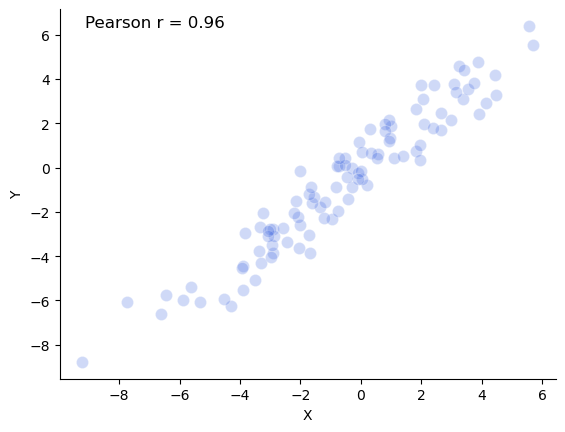

In [6]:
# plot a subject Y as function of X
subject_test = 42
print(f'Subject {subject_test}; b3={params[subject_test,3]:.2f}')
plotting.plot_scatter(np.dot(X[subject_test,:,:],params[subject_test,:]), 'X', Y[subject_test], 'Y')

In [7]:
# create a list of lists with X, Y for each subject
all_data = []
for subject_idx in range(nsubjects):
    thisX = X[subject_idx,:,:]
    thisY = Y[subject_idx,:]
    all_data += [[thisX, thisY]]

In [8]:
m, inv_h, posterior, NPL, NLPrior, NLL = EMfit(all_data, objfunc_dict['GLM'], param_names)

27407.782 (000), 20521.753 (001), 20521.664 (002), 20521.663 (003),  -- CONVERGED!!!!!


In [9]:
## Now store all relevant outputs in modout dict and save it
save_fit = False

# get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,inv_h,2)
nparams = len(param_names)

# Fill in general information
modout = {}
modout[modelID] = {}
modout[modelID]['date'] = datetime.date.today().strftime('%Y%m%d')

# Fill in fit information
est_params = m.T.copy()
for subj_idx in range(nsubjects):
    for param_idx, param_name in enumerate(param_names):
            est_params[subj_idx, param_idx] = m[param_idx, subj_idx]

modout[modelID]['fit'] = {}
modout[modelID]['fit']['norm_params'] = m
modout[modelID]['fit']['params'] = est_params
modout[modelID]['fit']['param_names'] = param_names
modout[modelID]['fit']['inverse_hess'] = inv_h
modout[modelID]['fit']['gauss.mu'] = posterior['mu']
modout[modelID]['fit']['gauss.sigma'] = posterior['sigma']
modout[modelID]['fit']['gauss.cov'] = covmat_out
try:
    modout[modelID]['fit']['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modout[modelID]['fit']['gauss.corr'] = np.eye(nparams)
modout[modelID]['fit']['npl'] = NPL  # note: this is the negative joint posterior likelihood
modout[modelID]['fit']['NLPrior'] = NLPrior
modout[modelID]['fit']['nll'] = NPL - NLPrior
modout[modelID]['fit']['lme'] = []

# Make sure you know if BIC is positive or negative! and replace lme with
# bic if covariance is negative.
# Error check that BICs are in a similar range
# Get subject specifics
goodHessian = np.zeros(nsubjects)
modout[modelID]['fit']['predicted_y'] = np.zeros((nsubjects, ntrials))
modout[modelID]['fit']['negll'] = np.zeros((nsubjects,))
modout[modelID]['fit']['BIC'] = np.zeros((nsubjects,))

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
for subj_idx in range(nsubjects):
    try:
        det_inv_hessian = np.linalg.det(inv_h[:, :, subj_idx])
        hHere = np.linalg.slogdet(inv_h[:, :, subj_idx])[1]
        L = -NPL - 0.5 * np.log(1 / det_inv_hessian) + (nparams / 2) * np.log(2 * np.pi)
        goodHessian[subj_idx] = 1
    except:
        print('Hessian is not positive definite')
        try:
            hHere = np.linalg.slogdet(inv_h[:,:,subj_idx])[1]
            L = np.nan
            goodHessian[subj_idx] = 0
        except:
            print('could not calculate')
            goodHessian[subj_idx] = -1
            L = np.nan
    modout[modelID]['fit']['lme'] = L
    modout[modelID]['fit']['goodHessian'] = goodHessian
    
    model_fits = glm_models.fit(m[:,subj_idx], X[subj_idx,:,:], Y[subj_idx], prior=None, output='all')

    # store model fits
    modout[modelID]['fit']['predicted_y'][subj_idx] = model_fits['predicted_y']
    modout[modelID]['fit']['negll'][subj_idx] = model_fits['negll']
    modout[modelID]['fit']['BIC'][subj_idx] = model_fits['BIC']

# Save output
if save_fit:
    with open(f'EMfit_{modelID}.pkl', 'wb') as f:
        pickle.dump(modout, f)

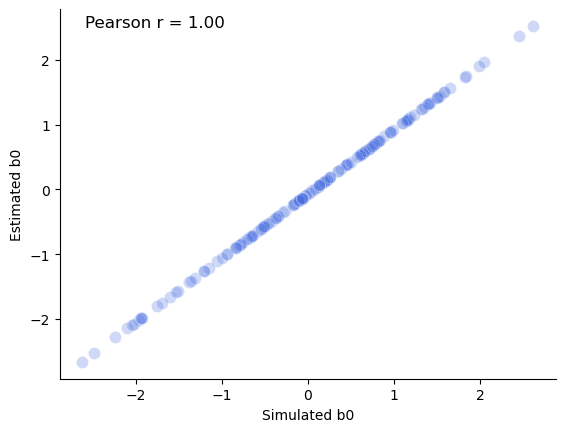

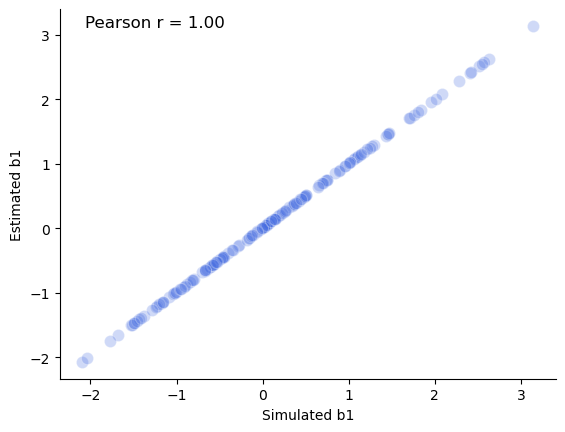

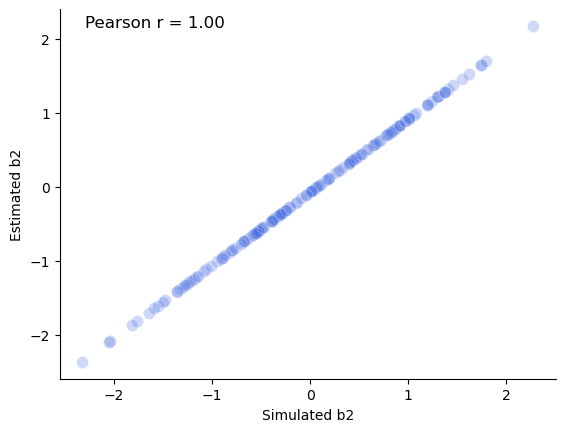

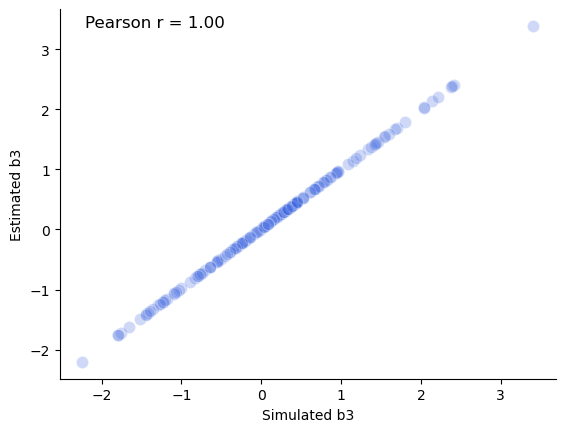

In [10]:
for param_idx, param_label in enumerate(param_names):
    simulated_param = params[:,param_idx]
    fitted_params = est_params[:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')